In [164]:
import numpy as np
import math
import matplotlib.pyplot as plt
import jax
import pennylane as qml
from jax import numpy as jnp
import optax
from scipy.integrate import trapezoid

import warnings
warnings.filterwarnings("ignore")

### Gaussian Distribution

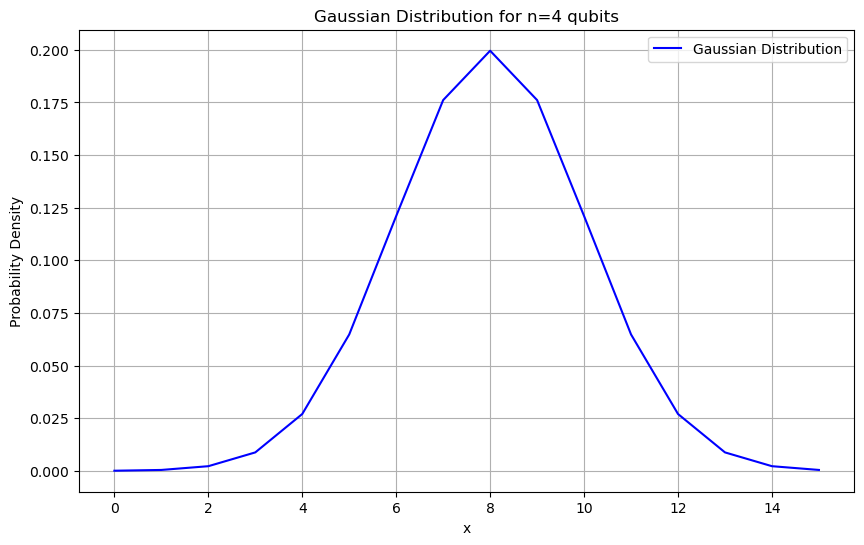

In [165]:
n_qubits = 4
# x values for 6 qubits range from 0 to 16
x = np.arange(0, 2**n_qubits)

# Parameters for the Gaussian distribution
mu = 2**(n_qubits-1)  # mean
sigma = 2**(n_qubits-1)/4  # standard deviation

# Gaussian distribution formula
gaussian_distribution = (1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2))

area = trapezoid(gaussian_distribution,x)
gaussian_distribution /= area

# Plot the Gaussian distribution
plt.figure(figsize=(10, 6))
plt.plot(x, gaussian_distribution, label='Gaussian Distribution', color='blue')
plt.title(f'Gaussian Distribution for n={n_qubits} qubits')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()
plt.show()

### Particle Number Distibution

In [166]:
def pnumber_distribution(distribution):
    p_distribution = np.zeros(n_qubits+1)
    
    for i in range(2**n_qubits):
        binary_string = format(i,'06b')
        num_of_ones = binary_string.count('1')
        p_distribution[num_of_ones] += distribution[i]
        
    #Normalize the distribution
    p_distribution/=p_distribution.sum()
    return p_distribution

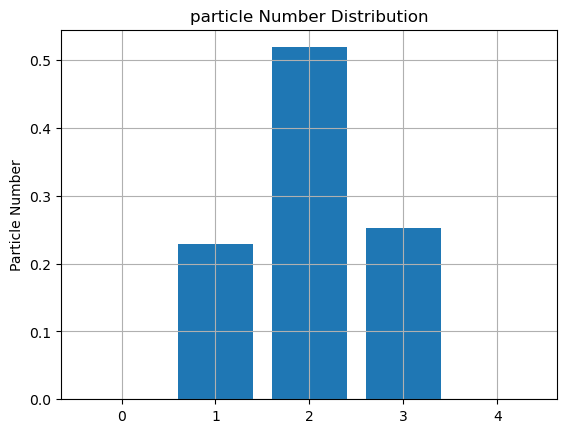

In [167]:
targetp_distribution = pnumber_distribution(gaussian_distribution)
plt.bar(range(n_qubits+1), targetp_distribution)
plt.title('particle Number Distribution')
plt.ylabel('Particle Number')
plt.xticks(range(n_qubits+1))
plt.grid(True)
plt.show()

### QCBM Circuit

In [168]:
dev = qml.device('default.qubit',wires=n_qubits)

def random_init(num_qubits,distribution=targetp_distribution):
    all_states = []
    for i in range(2**num_qubits):
        binary_string = format(i,'04b')
        all_states.append(binary_string)
    # all_state_dict = {i:0 for i in all_states}

    # a=np.random.choice(['0001','0010','0100','1000'],1)[0]
    # b=np.random.choice(['0011','0101','1001','0110','1100','1010'],1)[0]
    # c=np.random.choice(['0111','1011','1101','1110'],1)[0]
    
    # chosen_states = ['0000','0001','0011','0111','1111']
    # chosen_state_dict = dict(zip(chosen_states,np.sqrt(distribution)))
    amps = []
    
    for i in all_states:
        num_of_ones = i.count('1')
        if num_of_ones == 0:
            amps.append(distribution[0])
        elif num_of_ones == 1:
            amps.append(distribution[1]/4)
        elif num_of_ones == 2:
            amps.append(distribution[2]/6)
        elif num_of_ones == 3:
            amps.append(distribution[3]/4)
        else:
            amps.append(distribution[4])
    amps = np.sqrt(amps)        
    # all_state_dict.update(chosen_state_dict)
    
    
    #amplitudes
    # amps = list(all_state_dict.values())
    # norm = np.sqrt(sum(np.abs(amp)**2 for amp in amps))
    # amps = amps/norm
    
    #print(amps)
    qml.StatePrep(amps,wires=range(num_qubits))
    
def qcbm_circuit(params,num_qubits):
    
    rz_params = params[:num_qubits]
    ising_params = params[num_qubits:]
    
    for i in range(num_qubits):
        # qml.RX(ising_params[i],wires=i)
        qml.RZ(rz_params[i],wires=i)

    # qml.CNOT(wires=[0,1])
    # qml.CNOT(wires=[1,2])
    # qml.CNOT(wires=[2,3])
    # qml.CNOT(wires=[3,0])
    qml.IsingZZ(ising_params[0],wires=[0,1])
    qml.IsingZZ(ising_params[2],wires=[1,2])
    qml.IsingZZ(ising_params[1],wires=[2,3])
    qml.IsingZZ(ising_params[3],wires=[3,0])


@qml.qnode(dev)
def circuit(input_params,distibution=targetp_distribution,num_qubits=n_qubits):
    
    #Random state for pretraining
    random_init(num_qubits,distibution)
    
    #Layers of Rotation + Entangling gates
    for i in range(1):
        qml.Barrier(range(num_qubits))
        qcbm_circuit(params=input_params[i],num_qubits=num_qubits)
    return qml.probs()


### Loss Function

In [169]:
class MMD:
    def __init__(self,scales,space):
        gammas = 1/(2*(scales**2)).reshape(-1,1,1)
        sq_dists = np.abs(space[:,None] - space[None,:])**2
        self.K = np.sum(np.exp(-gammas * sq_dists), axis=0)/len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return px @ self.K @ py
    
    def __call__(self,px,py):
        pxy = px-py
        return self.k_expval(pxy,pxy)
    
class QCBM:
    def __init__(self,circ,mmd,py):
        self.circ = circ
        self.mmd = mmd
        self.py = py
    
    def mmd_loss(self,params):
        px = self.circ(params)
        return self.mmd(px,self.py), px

In [170]:
folds = 1
initial_params = []
for i in range(folds):
    #Each layer has 2*4=8 params i.e., 4 Rotation + 4 Entangling
    initial_params.append(np.random.rand(2*n_qubits).tolist())

### Training the Model

In [171]:
def update_step(params,opt_state):
    
    (loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss,has_aux=True)(params)
    
    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)
    
    kl_div = -np.sum(gaussian_distribution * np.nan_to_num(np.log(qcbm_probs / gaussian_distribution)))
    
    return params, opt_state, loss_val, kl_div

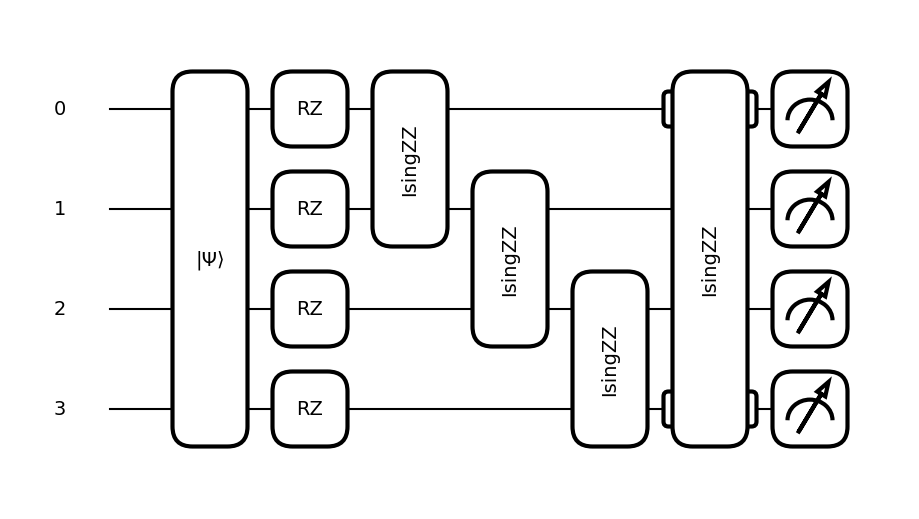

In [172]:
qml.draw_mpl(circuit,level='device')(input_params=initial_params)
plt.show()

In [173]:
#Calling MMD class
bandwidth = np.array([0.25,60])
space = np.arange(0,2**n_qubits)
mmd = MMD(bandwidth,space=space)

#Calling QCBM class to run the previous built circuit with random weights
qcbm = QCBM(circuit,mmd=mmd,py=gaussian_distribution)

#Call an optimizer
opt = optax.adam(learning_rate=1)
opt_state = opt.init(initial_params)

history = []
divs = []
parameters = []
n_iterations = 200

weights = initial_params

for i in range(n_iterations+1):
    weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
    
    if i%10==0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div}")
        #print(f"Params: {weights}")
    
    history.append(loss_val)
    divs.append(kl_div)
    parameters.append(weights)

Step: 0 Loss: 0.033700086176395416 KL_div:0.5143463679812195
Step: 10 Loss: 0.033700089901685715 KL_div:0.5143467465912855
Step: 20 Loss: 0.033700089901685715 KL_div:0.5143466817139074
Step: 30 Loss: 0.03370009362697601 KL_div:0.5143467349998835
Step: 40 Loss: 0.033700089901685715 KL_div:0.5143464366458452
Step: 50 Loss: 0.03370009362697601 KL_div:0.5143467009972298
Step: 60 Loss: 0.033700089901685715 KL_div:0.5143465177145519
Step: 70 Loss: 0.033700086176395416 KL_div:0.5143463883555776
Step: 80 Loss: 0.03370009362697601 KL_div:0.5143466314367956
Step: 90 Loss: 0.033700089901685715 KL_div:0.5143467310599492
Step: 100 Loss: 0.03370009735226631 KL_div:0.5143467626118179
Step: 110 Loss: 0.03370009735226631 KL_div:0.514346530742115
Step: 120 Loss: 0.03370009735226631 KL_div:0.5143467194549581
Step: 130 Loss: 0.033700089901685715 KL_div:0.5143464365174862
Step: 140 Loss: 0.03370009362697601 KL_div:0.5143466094309418
Step: 150 Loss: 0.03370009362697601 KL_div:0.5143467044684816
Step: 160 Lo

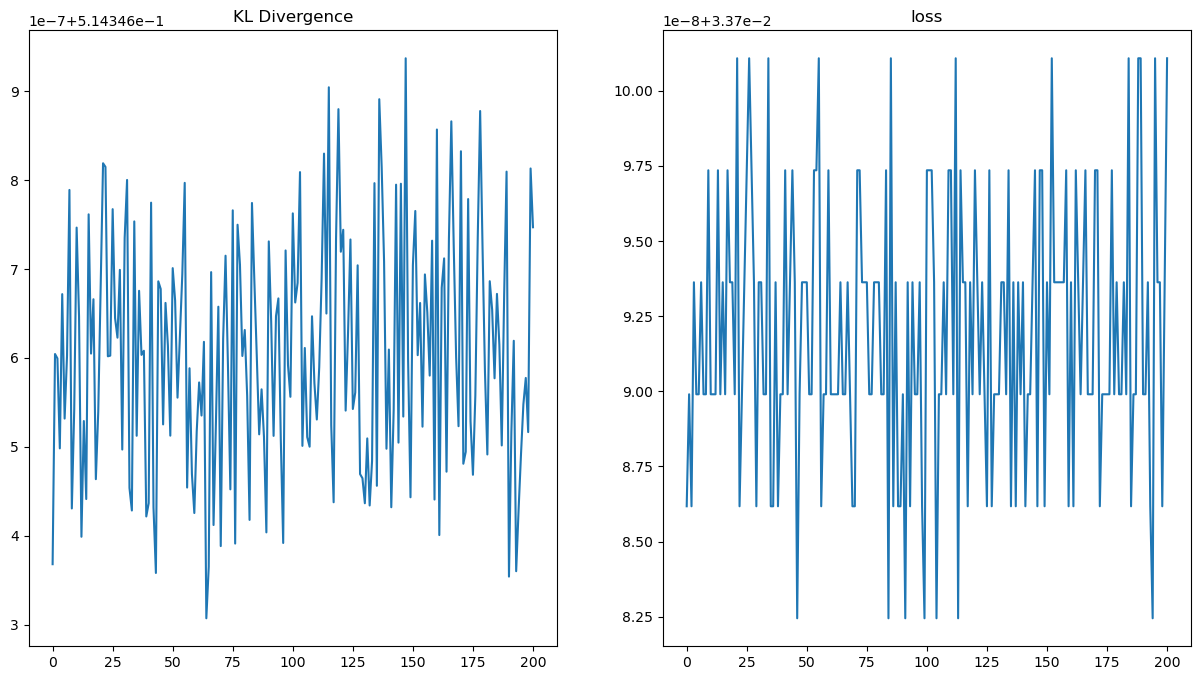

In [174]:
fig, axs = plt.subplots(1,2,figsize=(15,8))

axs[0].plot(divs)
axs[0].title.set_text('KL Divergence')

axs[1].plot(history)
axs[1].title.set_text('loss')


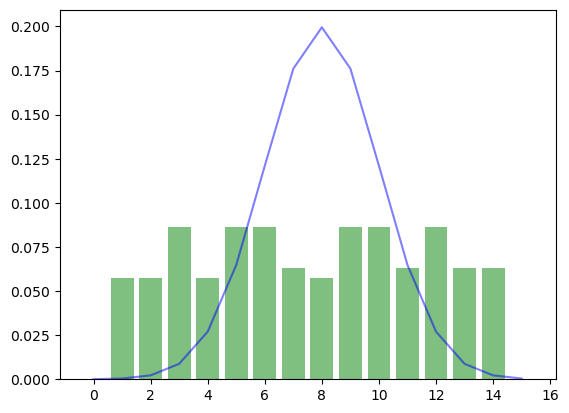

In [175]:
optimal_params = parameters[np.argmin(divs)]
qcbm_probs = circuit(optimal_params)
plt.bar(x,qcbm_probs,color='green',alpha=0.5,label='obtained_distribution')
plt.plot(x,gaussian_distribution,color='blue',alpha=0.5,label='target_distribution')

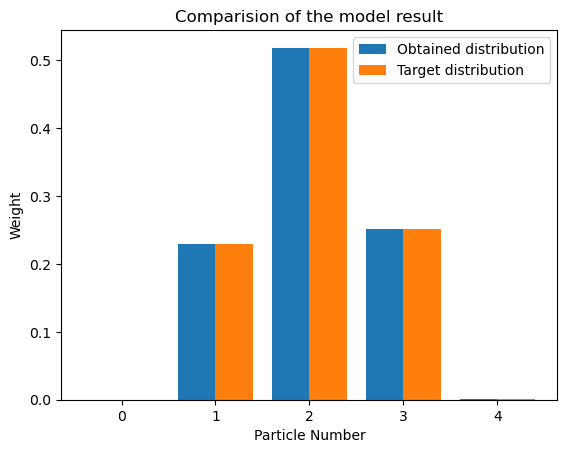

In [176]:
x_axis = np.arange(n_qubits+1)
obtained_pdistribution = pnumber_distribution(qcbm_probs)
plt.bar(x_axis-0.2,obtained_pdistribution,width=0.4,label='Obtained distribution')
plt.bar(x_axis+0.2,targetp_distribution,width=0.4,label='Target distribution')

plt.xticks(x_axis,range(n_qubits+1))
plt.xlabel('Particle Number')
plt.ylabel('Weight')
plt.title('Comparision of the model result')
plt.legend()
plt.show()